In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import re
import numpy as np
from paddleocr import PaddleOCR
from transformers import GPTNeoForCausalLM, GPT2Tokenizer
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
!pip install paddleocr transformers torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.6/544.6 kB 14.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 64.1 MB/s eta 0:00:00:00:01
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114248 sha256=6af5cc66340f3173427c8d3d27c288a2a576e1a253118b1507f9fb0e4fc02fd9
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [11]:
def extract_all_info_from_image(image):
    # Convert PIL Image to NumPy array
    if isinstance(image, Image.Image):
        image = np.array(image)

  
    assert isinstance(image, (np.ndarray, list, str, bytes)), "Invalid image format for PaddleOCR"

   
    ocr = PaddleOCR(use_angle_cls=True, lang='en')
    
    
    result = ocr.ocr(image)

   
    all_text_blocks = []

    
    date_patterns = [
        r'\b\d{1,2}[-/\.]\d{1,2}[-/\.]\d{2,4}\b',  
        r'\b\d{4}[-/\.]\d{1,2}[-/\.]\d{1,2}\b',    
        r'\b\d{1,2}[-/\.]\d{4}\b',                
        r'\b\d{4}\b'                              
    ]

    for line in result[0]:
        text = line[-1][0]
        all_text_blocks.append(text)

        
        for pattern in date_patterns:
            match = re.search(pattern, text)
            if match:
                all_text_blocks.append(f"Detected Date: {match.group(0)}")
                break

    
    return all_text_blocks

In [12]:
from transformers import GPTNeoForCausalLM, GPT2Tokenizer


model = GPTNeoForCausalLM.from_pretrained('EleutherAI/gpt-neo-1.3B')
tokenizer = GPT2Tokenizer.from_pretrained('EleutherAI/gpt-neo-1.3B')

def segregate_info_with_gpt_neo(extracted_info):
  
    info_string = "\n".join(extracted_info)
    
   
    prompt = f"Here is the extracted information from a product image:\n{info_string}\n\n" \
             f"Please identify and categorize the following fields:\n" \
             f"- Brand Name\n" \
             f"- Expiry Date\n" \
             f"- Product Size\n" \
             f"- Ingredients (if available)\n" \
             f"- Any other relevant information"

    
    inputs = tokenizer(prompt, return_tensors="pt")
    
    
    outputs = model.generate(**inputs, max_length=200)
    
   
    gpt_neo_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return gpt_neo_response

def extract_brand_from_gpt_response(gpt_response):
    # Ensure gpt_response is a string
    if not isinstance(gpt_response, str):
        raise TypeError("Expected gpt_response to be a string.")

    # Define pattern to extract brand name
    match = re.search(r"Brand Name:\s*([A-Za-z0-9\s]+)", gpt_response)
    
    brand_name = None
    if match:
        brand_name = match.group(1).strip()  
    
    
    if not brand_name:
        capitalized_words = re.findall(r'\b[A-Z][a-zA-Z0-9]+\b', gpt_response)
        if capitalized_words:
            brand_name = capitalized_words[0] 
    
    return brand_name


brand_counter = {}

def track_brand_occurrences(brand_name):
    if brand_name in brand_counter:
        brand_counter[brand_name] += 1
    else:
        brand_counter[brand_name] = 1

def count_brands(gpt_response):
   
    brand_name = extract_brand_from_gpt_response(gpt_response)
    
    
    track_brand_occurrences(brand_name)
    
  
    return brand_counter



In [13]:
brand_counter = {}

def track_brand_occurrences(brand_name):
    if brand_name in brand_counter:
        brand_counter[brand_name] += 1
    else:
        brand_counter[brand_name] = 1



In [14]:
def count_brands(gpt_response):
    
    brand_name = extract_brand_from_gpt_response(gpt_response)  
    track_brand_occurrences(brand_name)
    return brand_counter




In [24]:
from PIL import Image
import matplotlib.pyplot as plt
def main(image_path):
   
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')  
    plt.show()

    
    extracted_info = extract_all_info_from_image(image)
   

   
    gpt_neo_response = segregate_info_with_gpt_neo(extracted_info)
    print("Extracted information:")
    print(gpt_neo_response)

   
    brand_count = count_brands(gpt_neo_response)
    print("\nBrand Count:")
    print(brand_count)


In [25]:

image_path1 = '/kaggle/input/detdata/details-of-expiry-date-and-manufacturing-date-with-bar-code-on-product-label-2WRF7HW.jpg'
image_path2 ='/kaggle/input/proddata/61WHygCBRHL._AC_UF10001000_QL80_.jpg'
image_path3 ='/kaggle/input/proddata/close-up-of-2019-expiration-date-on-canned-food-RAEY4F.jpg'
image_path4 = '/kaggle/input/proddata/medicine-capsule-on-white-background-260nw-234431833.webp'

In [26]:
image_path

'/kaggle/input/detdata/details-of-expiry-date-and-manufacturing-date-with-bar-code-on-product-label-2WRF7HW.jpg'

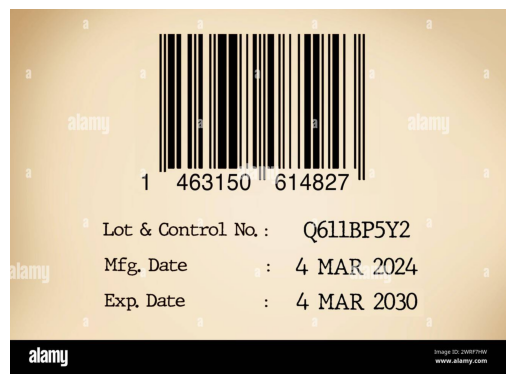

[2024/10/20 18:15:49] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Extracted information:
Here is the extracted information from a product image:
alamy
alamy
463150614827
Lot & Control No. :
Q611BP5Y2
Mfg. Date
alamy
4 MAR 2024
Detected Date: 2024
Exp. Date
4 MAR 2030
Detected Date: 2030
alamy
Image ID:2WRF7HW
www.alamy.com

Please identify and categorize the following fields:
- Brand Name
- Expiry Date
- Product Size
- Ingredients (if available)
- Any other relevant information

Please provide the following information:
- Name of the product
- Name of the manufacturer
- Name of the distributor
- Name of the supplier
- Name of the retailer
- Name of the retailer
- Name of the retailer
- Name of the retailer
- Name of the retailer
- Name of the retailer
- Name of the

Brand Count:
{'Here': 9}


In [32]:
main(image_path1)

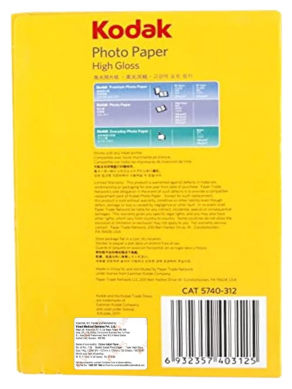

[2024/10/20 17:07:39] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Extracted information:
Here is the extracted information from a product image:
Kodak
Photo Paper
High Gloss
CAT5740-312
Viaed MedicalSrstams Pyt.Ltd.
 - 400093
odty Colour nk Pap
Si/Pkg/SR-127mm x178mm100St/180GSM
No.of Ps1ModatKod
ypeHigh Gs
Month and Ysar of pacig
M.R.P.ncoali tsRa.310.00
6932357403125
Or any cempiaitts, contart Csstamer Care af abovt aderees

Please identify and categorize the following fields:
- Brand Name
- Expiry Date
- Product Size
- Ingredients (if available)
- Any other relevant information

Please provide the following information:
- Product Name
- Product Description
- Product Code
- Product

Brand Count:
{'Here': 5}


In [28]:
main(image_path2)

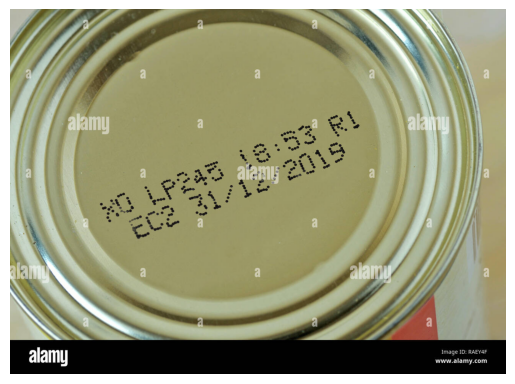

[2024/10/20 17:07:57] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Extracted information:
Here is the extracted information from a product image:
a
a
a
alamy
alamy
a
18:53R1
aiamy
2019
Detected Date: 2019
a
...
EC2
a
a
alami
alamy
a
a
a
alamy
Image ID:RAEY4F
www.alamy.com

Please identify and categorize the following fields:
- Brand Name
- Expiry Date
- Product Size
- Ingredients (if available)
- Any other relevant information

Please provide the following information:
- Name of the product
- Name of the manufacturer
- Name of the distributor
- Name of the retailer
- Name of the store
- Name of the country
- Name of the city
- Name of the state
- Name of the country
- Name of the city
- Name of the state
- Name of the

Brand Count:
{'Here': 6}


In [29]:
main(image_path3)

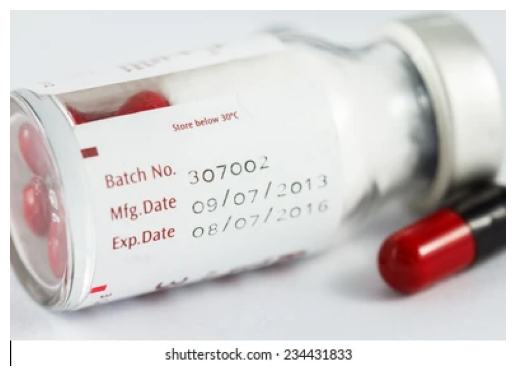

[2024/10/20 17:08:40] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Extracted information:
Here is the extracted information from a product image:
Batch No.307002
Mfg.Date 09/07/2013
Detected Date: 09/07/2013
Exp.Date
e08/07/2016
Detected Date: 07/2016
shutterstock.com  234431833

Please identify and categorize the following fields:
- Brand Name
- Expiry Date
- Product Size
- Ingredients (if available)
- Any other relevant information

A:

I think you are looking for this:

Batch No.307002
Mfg.Date 09/07/2013
Detected Date: 09/07/2013
Exp.Date
e08/07/2016
Detected Date: 07/2016
shutterstock.com  234431833

The first two fields are the batch number and the expiry date. The third field is the product size

Brand Count:
{'Here': 7}


In [30]:
main(image_path4)

In [ ]:
!pip install paddlepaddle


In [ ]:
!pip install gradio

In [ ]:
!pip install paddleocr

In [ ]:
!git clone https://github.com/PaddlePaddle/PaddleOCR.git

In [ ]:
!python3 -m pip install paddlepaddle-gpu